In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
election_dates = ['7 January 1789', '2 November 1792', '4 November 1796', '31 October 1800', '2 November 1804', '4 November 1808', '30 October 1812', '1 November 1816', '3 November 1820', '29 October 1824', '31 October 1828', '2 November 1832', '4 November 1836', '30 October 1840', '1 November 1844', '7 November 1848', '2 November 1852', '4 November 1856', '6 November 1860', '8 November 1864', '3 November 1868', '5 November 1872', '7 November 1876', '2 November 1880', '4 November 1884', '6 November 1888', '8 November 1892', '3 November 1896', '6 November 1900', '8 November 1904', '3 November 1908', '5 November 1912', '7 November 1916', '2 November 1920', '4 November 1924', '6 November 1928', '8 November 1932', '3 November 1936', '5 November 1940', '7 November 1944', '2 November 1948', '4 November 1952', '6 November 1956', '8 November 1960', '3 November 1964', '5 November 1968', '7 November 1972', '2 November 1976', '4 November 1980', '6 November 1984', '8 November 1988', '3 November 1992', '5 November 1996', '7 November 2000', '2 November 2004', '4 November 2008', '6 November 2012', '8 November 2016', '3 November 2020']
election_dates = pd.to_datetime(election_dates, format='%d %B %Y')

In [3]:
def get_tables(url='https://www.senate.gov/legislative/nominations/SupremeCourtNominations1789present.htm'):
    url = url
    source = requests.get(url).text
    soup = BeautifulSoup(source, 'lxml')
    tables = soup.find_all('table')
    
    return tables

def result_code_getter():
    tables = get_tables()
    df = pd.read_html(str(tables[0]))[3]
    tmp = df.iloc[6:12, 1].str.split('-')
    codes = [t[0].strip() for t in tmp]
    words = [t[1].strip('1234567890() ') for t in tmp]
    result_code_dict = dict(zip(codes, words))
    return result_code_dict

def get_dataframe():
    tables = get_tables()

    df = pd.read_html(str(tables[0]))[2]

    return df

def munge_data(df):
    df.drop([1, 3, 5, 7, 9], axis=1, inplace=True)
    df.columns = df.iloc[0]
    df.drop(0, inplace=True)

    pres_col = []
    rows_to_drop = []
    pres = None
    for index, row in df.iterrows():
        if row[0]==row[1]:
            pres = row[0]
            rows_to_drop.append(index)
        pres_col.append(pres)
    
    df['Predident'] = pres_col
    df.drop(rows_to_drop, inplace=True)
    df.columns = ['Nominee', 'To Replace', 'Nominated Date', 'Vote', 'Result', 'Result Date', 'President']
    df['Nominated Date'] = pd.to_datetime(df['Nominated Date'], format='%b %d, %Y')
    df['Result Date'] = pd.to_datetime(df['Result Date'], format='%b %d, %Y')
    df.Nominee = df.Nominee.str.strip('1234567890')
    df.reset_index(drop=True, inplace=True)

    result_code_dict = result_code_getter()
    df.Result = df.Result.map(result_code_dict)

    df.Vote = df.Vote.fillna('None')
    df.Vote = df.Vote.str.replace('V', 'Voice')
    df.Vote = df.Vote.str.split()
    df.Vote = df.Vote.apply(lambda x: x[0])

    df['Days to Result'] = df['Result Date'] - df['Nominated Date']
    df['Days to Result'] = df['Days to Result'].apply(lambda x: x.days)

    def next_election(row):
        try:
            next_elect = min([date for date in election_dates if date>row['Result Date']])
            time_till = next_elect - row['Result Date']
            return time_till.days
        except:
            return np.nan

    df['Days to Election'] = df.apply(next_election, axis=1)

    def vote_split(row):
        try:
            votes = row.Vote.split('-')
            votes = list(map(int, votes))
            return max(votes)/sum(votes)
        except:
            return np.nan

    df['Vote Share'] = df.apply(vote_split, axis=1)

    return df

def look_at_that_dot(col_name):
    data = df[df['Result'] == 'Confirmed and served']
    plt.scatter(data['Nominated Date'], data[col_name], s=5)

    ACB = df[df['Result'] == 'Confirmed and served'][df['Nominee'] == 'Barrett, Amy Coney']
    plt.scatter(ACB['Nominated Date'], ACB[col_name], color="red")

    plt.title('Look at that dot')
    plt.ylabel(col_name) if col_name != 'Days to Result' else plt.ylabel('Days to Confirm')
    plt.show()

In [4]:
df = get_dataframe()
df = munge_data(df)

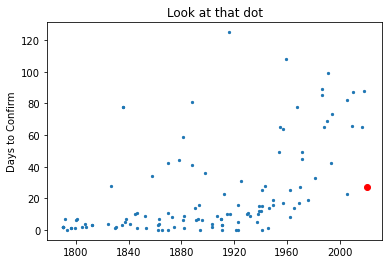

In [5]:
look_at_that_dot('Days to Result')

In [14]:
# Average time to confirm since 1970-01-01
print(df[df['Result'] == 'Confirmed and served'][df['Nominated Date'] > np.datetime64('1970-01-01')]['Days to Result'].mean())

# Now excluding ACB
print(df[df['Result'] == 'Confirmed and served'][df['Nominated Date'] > np.datetime64('1970-01-01')][df['Nominated Date'] < np.datetime64('2020-09-01')]['Days to Result'].mean())

59.63157894736842
61.44444444444444


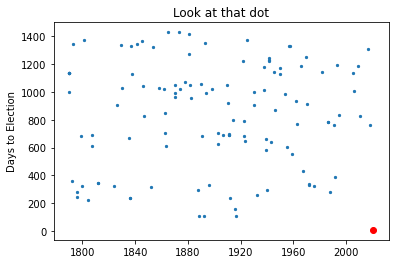

In [7]:
look_at_that_dot('Days to Election')

In [8]:
df[df['Result'] == 'Confirmed and served'][df['Days to Election']<200]

,Nominee,To Replace,Nominated Date,Vote,Result,Result Date,President,Days to Result,Days to Election,Vote Share
0,"Barrett, Amy Coney",Ginsburg,2020-09-29,52-48,Confirmed and served,2020-10-26,"President Trump, Donald",27.0,8.0,0.520000
61,"Clarke, John",Hughes,1916-07-14,Voice,Confirmed and served,1916-07-24,"President Wilson, Woodrow",10.0,106.0,NaN
62,"Brandeis, Louis",Lamar,1916-01-28,47-22,Confirmed and served,1916-06-01,"President Wilson, Woodrow",125.0,159.0,0.681159
80,"Shiras, George, Jr.",Bradley,1892-07-19,Voice,Confirmed and served,1892-07-26,President Benjamin Harrison,7.0,105.0,NaN
83,"Fuller, Melville",Waite,1888-04-30,41-20,Confirmed and served,1888-07-20,"President Cleveland, Grover",81.0,109.0,0.672131


In [15]:
# Least days from confirmation to election between 1920 and 2020 (ACB excluded)
min(df[df['Result'] == 'Confirmed and served'][df['Nominated Date'] > np.datetime64('1920-01-01')][df['Nominated Date'] < np.datetime64('2020-09-01')]['Days to Election'])

258.0

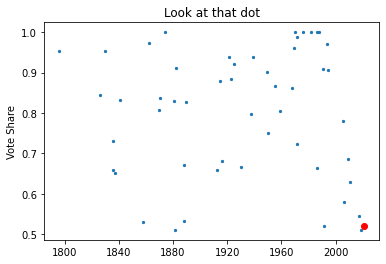

In [10]:
look_at_that_dot('Vote Share')

In [23]:
df[df['Result']=='Confirmed and served'][df['Vote Share'] < float(df[df['Nominee'] == 'Barrett, Amy Coney']['Vote Share'])]

,Nominee,To Replace,Nominated Date,Vote,Result,Result Date,President,Days to Result,Days to Election,Vote Share
1,"Kavanaugh, Brett",Kennedy,2018-07-10,50-48,Confirmed and served,2018-10-06,"President Trump, Donald",88.0,759.0,0.510204
88,Stanley Matthews,Swayne,1881-03-14,24-23,Confirmed and served,1881-05-12,"President Garfield, James",59.0,1272.0,0.510638
